In [ ]:
from viscnn.model_prep.utils import load_prepped_model_params, load_prepped_model

model = load_prepped_model('alexnet_sparse')
params = load_prepped_model_params('alexnet_sparse')


In [ ]:
##DATA LOADER###
import torch.utils.data as data
import torchvision.datasets as datasets
from viscnn.data_loading import rank_image_data
from viscnn.dissected_Conv2d import *
from copy import deepcopy

kwargs = {'num_workers': params['num_workers'], 'pin_memory': True, 'sampler':None} if 'cuda' in params['device'] else {}


image_loader = data.DataLoader(rank_image_data('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/alexnet10/ranking_images',
                                                params['preprocess'],
                                                label_file_path = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/labels.txt',class_folders=True),
                                                batch_size=250,
                                                shuffle=False,
                                                **kwargs)




## Grasp

In [ ]:
#add grasp modules
net = dissect_model(deepcopy(model),device='cuda:0',dissect=False)

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F

import copy
import types


from viscnn.utils import nodeid_2_perlayerid

def count_total_parameters(net):
    total = 0
    for m in net.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            total += m.weight.numel()
    return total


def count_fc_parameters(net):
    total = 0
    for m in net.modules():
        if isinstance(m, (nn.Linear)):
            total += m.weight.numel()
    return total


def feature_GraSP(net, target_node, ratio, dataloader, device, num_iters= None, eps = 1e-10, intv=20, params=None, rank_field = 'image'):
    
    
    #prep model to stop at feature
    net = dissect_model(net,device=device,dissect=False)
    
    if target_node != 'loss':
        if not isinstance(target_node,list) or isinstance(target_node,tuple): 
            #convert nodeid to perlayer_id
            target_node_layer,target_node_within_layer_id,target_node_layer_name = nodeid_2_perlayerid(target_node,params)
            net=set_model_target_node(net,target_node_layer,target_node_within_layer_id)
        else:
            target_node_layer_name,target_node_within_layer_id = target_node[0], target_node[1] 
            net=set_model_target_node(net,target_node_layer_name,target_node_within_layer_id)
        print('getting scores for target %s:%s'%(target_node_layer_name,str(target_node_within_layer_id)))

    #set up loss
    if params is not None:
        criterion = params['criterion']
    else:
        criterion = torch.nn.CrossEntropyLoss()
                
    
    keep_ratio = 1-ratio
    old_net = net

    net = copy.deepcopy(net)
    net.zero_grad()
    weights = []
    total_parameters = count_total_parameters(net)
    fc_parameters = count_fc_parameters(net)

    '''
    fc_layers = []
    for layer in net.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            if isinstance(layer, nn.Linear):
                fc_layers.append(layer)
            weights.append(layer.weight)
    '''

    for layer in net.modules():
        if isinstance(layer, hooked_Conv2d):
            weights.append(layer.from_conv.weight)
            if layer.name == target_node_layer_name:
                break

    inputs_one = []
    targets_one = []

    grad_w = None
    grad_f = None
    for w in weights:
        w.requires_grad_(True)


    dataloader_iter = iter(dataloader)
    if not num_iters:
        num_iters = len(dataloader_iter)
        
    for it in range(num_iters):
        print("(1): Iterations %d/%d." % (it, num_iters))
        inputs, targets = next(dataloader_iter)
        N = inputs.shape[0]
        din = copy.deepcopy(inputs)
        dtarget = copy.deepcopy(targets)

        start = 0

        while start < N:
            end = min(start+intv, N)
            print('(1):  %d -> %d.' % (start, end))
            inputs_one.append(din[start:end])
            targets_one.append(dtarget[start:end])
            
            try:
                outputs = net.forward(inputs[start:end].to(device)) / 200  # divide by temperature to make it uniform
                if target_node == 'loss':
                    targets = max_likelihood_for_no_target(targets,output) 
                    loss = criterion(outputs, targets[start:end].to(device))    #running backward pass calls all the hooks and calculates the ranks of all edges and nodes in the graph 
            except TargetReached:
                print('target node %s reached, halted forward pass'%str(target_node))
                print(target_node_layer_name)
                loss = get_optim_target_from_model(net,target_node_layer_name)


            grad_w_p = autograd.grad(loss, weights, create_graph=False)
            
            if grad_w is None:
                grad_w = list(grad_w_p)
            else:
                for idx in range(len(grad_w)):
                    grad_w[idx] += grad_w_p[idx]
            start = end

    for it in range(len(inputs_one)):
        print("(2): Iterations %d/%d." % (it, len(inputs_one)))
        inputs = inputs_one.pop(0).to(device)
        targets = targets_one.pop(0).to(device)
        
        try:
            outputs = net.forward(inputs) / 200  # divide by temperature to make it uniform
            if target_node == 'loss':
                loss = criterion(outputs, targets)    #running backward pass calls all the hooks and calculates the ranks of all edges and nodes in the graph 
        except TargetReached:
            print('target node %s reached, halted forward pass'%str(target_node))
            loss = get_optim_target_from_model(net,target_node_layer_name)


        grad_f = autograd.grad(loss, weights, create_graph=True)
        z = 0
        count = 0
        for layer in net.modules():
            if isinstance(layer, hooked_Conv2d) or isinstance(layer, nn.Linear):
                z += (grad_w[count] * grad_f[count]).sum()
                if layer.name == target_node_layer_name:
                    break
                
                count += 1
                
        z.backward()

    grads = dict()
    old_modules = list(old_net.modules())
    for idx, layer in enumerate(net.modules()):
        if isinstance(layer, hooked_Conv2d) or isinstance(layer, nn.Linear):
            grads[layer.name] = -layer.from_conv.weight.data * layer.from_conv.weight.grad  # -theta_q Hg
            if layer.name == target_node_layer_name:
                break
                
    all_scores = torch.cat([torch.flatten(x) for x in grads.values()])
    norm_factor = torch.abs(torch.sum(all_scores)) + eps
    print("** grasp norm factor:", norm_factor)
    for layer in grads:
        grads[layer] = grads[layer]/norm_factor
        grads[layer] = grads[layer].to('cpu')
    return grads

    '''
    old_modules = list(old_net.modules())
    for idx, layer in enumerate(net.modules()):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            grads[old_modules[idx]] = -layer.weight.data * layer.weight.grad  # -theta_q Hg
    
    # Gather all scores in a single vector and normalise
    all_scores = torch.cat([torch.flatten(x) for x in grads.values()])
    norm_factor = torch.abs(torch.sum(all_scores)) + eps
    print("** norm factor:", norm_factor)
    all_scores.div_(norm_factor)

    num_params_to_rm = int(len(all_scores) * (1 - keep_ratio))
    threshold, _ = torch.topk(all_scores, num_params_to_rm, sorted=True)
    # import pdb; pdb.set_trace()
    acceptable_score = threshold[-1]
    print('** accept: ', acceptable_score)
    keep_masks = dict()
    for m, g in grads.items():
        keep_masks[m] = ((g / norm_factor) <= acceptable_score).float()

    print(torch.sum(torch.cat([torch.flatten(x == 1) for x in keep_masks.values()])))

    return keep_masks
    '''

In [ ]:
grasp_scores = feature_GraSP(model,1000 ,.9, image_loader, params['device'], params = params)

In [ ]:
torch.mean(keep_masks['features_0'],dim=(1,2,3)).shape


mean_masks = {}
max_masks = {}


In [ ]:
import pandas as pd
import plotly

node_columns = ['node_num','layer_name','layer','node_num_by_layer','graspmean_rank']
edge_columns = ['edge_num','layer_name','layer','out_channel','in_channel','graspmean_rank','graspmin_rank']

node_biglist = []
edge_biglist = []

edge_color_dict = {0:'r',
                   1:'g',
                   2:'b'}

node_num = 0
layer = 0
for layer_name in grasp_scores:
    print(layer_name)
    for node_num_by_layer in range(grasp_scores[layer_name].shape[0]):
        node_mean = float(torch.mean(grasp_scores[layer_name][node_num_by_layer,:,:,:]))
        node_biglist.append([node_num,layer_name,layer,node_num_by_layer,node_mean])
        for in_channel in range(grasp_scores[layer_name].shape[1]):
            edge_mean = float(torch.mean(grasp_scores[layer_name][node_num_by_layer,in_channel,:,:]))
            edge_min = float(torch.min(grasp_scores[layer_name][node_num_by_layer,in_channel,:,:]))
            edge_out = str(params['layer_nodes'][layer][1][node_num_by_layer])
            if layer == 0:
                edge_in = edge_color_dict[in_channel]
            else:
                edge_in = str(params['layer_nodes'][layer-1][1][in_channel])
            edge_name = edge_in+'-'+edge_out
            edge_biglist.append([edge_name,layer_name,layer,node_num_by_layer,in_channel,edge_mean,edge_min])
        node_num +=1
    layer +=1
 
node_df = pd.DataFrame(node_biglist,columns=node_columns)
edge_df = pd.DataFrame(edge_biglist,columns = edge_columns) 

In [ ]:
x = torch.tensor(([[1.,2.,3.],[4.,5.,6.]],
                 [[7.,8.,9.],[10.,11.,12.]]))

In [ ]:
import plotly.express as px
df = edge_df # iris is a pandas DataFrame
fig = px.violin(df, x="layer", y="graspmean_rank",hover_data=['edge_num'])
fig.show()

## Skeletalization

In [ ]:
#Skeletal exponential  scheduler 

from math import log, exp

k = 1000 #unpruned parameter target
m = 10000 #parameter number before pruning
T=10   #pruning steps
def k_at_t(t,k=k,T=T,m=m):
    return exp(t/T*log(k)+(1-t/T)*log(m))

## SNIP

In [ ]:

   
import torch
import torch.nn as nn
import torch.nn.functional as F

import copy
import types

from math import log, exp, ceil


def snip_forward_conv2d(self, x):
        return F.conv2d(x, self.weight * self.weight_mask, self.bias,
                        self.stride, self.padding, self.dilation, self.groups)


def snip_forward_linear(self, x):
        return F.linear(x, self.weight * self.weight_mask, self.bias)


def SNIP(net, dataloader, target_node='loss', full_dataset = True, keep_ratio=.1, num_params_to_keep=None, device=None, structure='weights', mask=None):
    '''
    if num_params_to_keep is specified, this argument overrides keep_ratio
    '''

    assert structure in ('weights','kernels','filters')    
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
  



    # Monkey-patch the Linear and Conv2d layer to learn the multiplicative mask
    # instead of the weights
    count = 0
    for layer in net.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            if mask is not None and count < len(mask): #we have a mask for these weights 
                layer.weight_mask = nn.Parameter(mask[count])
            else:
                layer.weight_mask = nn.Parameter(torch.ones_like(layer.weight))
            #nn.init.xavier_normal_(layer.weight)
            layer.weight.requires_grad = False
            count += 1

        # Override the forward methods:
        if isinstance(layer, nn.Conv2d):
            layer.forward = types.MethodType(snip_forward_conv2d, layer)

        if isinstance(layer, nn.Linear):
            layer.forward = types.MethodType(snip_forward_linear, layer)
    
    #do we iterate through the whole dataset or not
    iter_dataloader = iter(dataloader)
    
    iters = 1
    if full_dataset:
        iters = len(iter_dataloader)
    
    
    grads_abs = [] #computed scores
    
    for it in range(iters):
        # Grab a single batch from the training dataset
        inputs, targets = next(iter_dataloader)
        inputs = inputs.to(device)
        targets = targets.to(device)




        # Compute gradients (but don't apply them)
        net.zero_grad()
        outputs = net.forward(inputs)
        loss = F.nll_loss(outputs, targets)
        loss.backward()

        #get weight-wise scores
        if grads_abs == []:
            for layer in net.modules():
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    grads_abs.append(torch.abs(layer.weight_mask.grad))
        else:
            count = 0
            for layer in net.modules():
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    grads_abs[count] += torch.abs(layer.weight_mask.grad)        
                    count += 1
                
                
    #structure pruning by weights, kernels, or filters   
    
    if structure == 'weights':
        structure_grads_abs = grads_abs
    elif structure == 'kernels':
        structure_grads_abs = []
        for grad in grads_abs:
            if len(grad.shape) == 4: #conv2d layer
                structure_grads_abs.append(torch.mean(grad,dim = (2,3))) #average across height and width of each kernel
    else:
        structure_grads_abs = []
        for grad in grads_abs:
            if len(grad.shape) == 4: #conv2d layer
                structure_grads_abs.append(torch.mean(grad,dim = (1,2,3))) #average across channel height and width of each filter
        

    # Gather all scores in a single vector and normalise
    all_scores = torch.cat([torch.flatten(x) for x in structure_grads_abs])
    norm_factor = torch.sum(all_scores)
    all_scores.div_(norm_factor)
    
    #get num params to keep
    if num_params_to_keep is None:
        num_params_to_keep = int(len(all_scores) * keep_ratio)
    threshold, _ = torch.topk(all_scores, num_params_to_keep, sorted=True)
    acceptable_score = threshold[-1]

    keep_masks = []

    for g in structure_grads_abs:
        keep_masks.append(((g / norm_factor) >= acceptable_score).float())

    #print(torch.sum(torch.cat([torch.flatten(x == 1) for x in keep_masks])))

    return(keep_masks)

    
def gradxweight_SNIP(net, keep_ratio, train_dataloader, device):    
        # TODO: shuffle?

    # Grab a single batch from the training dataset
    inputs, targets = next(iter(train_dataloader))
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Let's create a fresh copy of the network so that we're not worried about
    # affecting the actual training-phase
    net = copy.deepcopy(net)

    # Compute gradients (but don't apply them)
    net.zero_grad()
    outputs = net.forward(inputs)
    loss = F.nll_loss(outputs, targets)
    loss.backward()

    grads_abs = []
    for layer in net.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            grads_abs.append(torch.abs(layer.weight.grad*layer.weight.data))

    # Gather all scores in a single vector and normalise
    all_scores_flat = torch.cat([torch.flatten(x) for x in grads_abs])
    norm_factor = torch.sum(all_scores_flat)
    for grad in grads_abs:
        grad = grad/norm_factor
    all_scores_flat.div_(norm_factor)
    return grads_abs, all_scores_flat
    '''
    num_params_to_keep = int(len(all_scores) * keep_ratio)
    threshold, _ = torch.topk(all_scores, num_params_to_keep, sorted=True)
    acceptable_score = threshold[-1]

    keep_masks = []
    for g in grads_abs:
        keep_masks.append(((g / norm_factor) >= acceptable_score).float())

    print(torch.sum(torch.cat([torch.flatten(x == 1) for x in keep_masks])))

    return(keep_masks)
    '''

    
    
def apply_prune_mask(net, keep_masks):

    # Before I can zip() layers and pruning masks I need to make sure they match
    # one-to-one by removing all the irrelevant modules:
    prunable_layers = filter(
        lambda layer: isinstance(layer, nn.Conv2d) or isinstance(
            layer, nn.Linear), net.modules())

    for layer, keep_mask in zip(prunable_layers, keep_masks):
        assert (layer.weight.shape == keep_mask.shape)

        def hook_factory(keep_mask):
            """
            The hook function can't be defined directly here because of Python's
            late binding which would result in all hooks getting the very last
            mask! Getting it through another function forces early binding.
            """

            def hook(grads):
                return grads * keep_mask

            return hook

        # mask[i] == 0 --> Prune parameter
        # mask[i] == 1 --> Keep parameter

        # Step 1: Set the masked weights to zero (NB the biases are ignored)
        # Step 2: Make sure their gradients remain zero
        layer.weight.data[keep_mask == 0.] = 0.
        layer.weight.register_hook(hook_factory(keep_mask))
        
        
def expand_structured_mask(mask,net):
    '''Structured mask might have shape (filter, channel) for kernel structured mask, but the weights have
        shape (filter,channel,height,width), so we make a new weight wise mask based on the structured mask'''

    weight_mask = []
    count=0
    for layer in net.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            if count < len(mask):
                weight_mask.append(mask[count])
                while len(weight_mask[-1].shape) < 4:
                    weight_mask[-1] = weight_mask[-1].unsqueeze(dim=-1)
                weight_mask[-1] = weight_mask[-1].expand(layer.weight.shape)
            count+= 1
    return weight_mask


def force_pruning(net, dataloader, T=10,full_dataset = True, keep_ratio=.1, num_params_to_keep=None, device=None, structure='weights', mask=None):    #progressive skeletonization

    
    assert structure in ('weights','kernels','filters')
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
    total_params = 0

    for layer in net.modules():
        if structure == 'weights' and (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)):
            total_params += len(layer.weight.flatten())
        elif isinstance(layer, nn.Conv2d):
            if structure == 'kernels':
                total_params += int(layer.weight.shape[0]*layer.weight.shape[1])
            else:
                total_params += int(layer.weight.shape[0])
    
    if num_params_to_keep is None:
        num_params_to_keep = ceil(keep_ratio*total_params)
    else:
        keep_ratio = num_params_to_keep/total_params       #num_params_to_keep arg overrides keep_ratio
    
    print('pruning %s'%structure)
    print('total parameters: %s'%str(total_params))
    print('parameters after pruning: %s'%str(num_params_to_keep))
    print('keep ratio: %s'%str(keep_ratio))
  

    print("Pruning with %s pruning steps"%str(T))
    for t in range(1,T+1):
        print('step %s'%str(t))
        
        k = ceil(exp(t/T*log(num_params_to_keep)+(1-t/T)*log(total_params))) #exponential schedulr
         
        print('%s params'%str(k))
        
        #SNIP
        struct_mask = SNIP(net, dataloader, num_params_to_keep=k, structure=structure, mask=mask, full_dataset = full_dataset, device=device)
        if structure is not 'weights':
            mask = expand_structured_mask(struct_mask,net) #this weight mask will get applied to the network on the next iteration
        
    return struct_mask
        

In [ ]:
##DATA LOADER###
import torch.utils.data as data
import torchvision.datasets as datasets
from viscnn.data_loading import rank_image_data
from viscnn.dissected_Conv2d import *
from copy import deepcopy

kwargs = {'num_workers': params['num_workers'], 'pin_memory': True, 'sampler':None} if 'cuda' in params['device'] else {}


image_loader = data.DataLoader(rank_image_data('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/alexnet10/ranking_images',
                                                params['preprocess'],
                                                label_file_path = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/labels.txt',class_folders=True),
                                                batch_size=250,
                                                shuffle=False,
                                                **kwargs)



In [ ]:
mask = force_pruning(model, image_loader,structure='kernels')

In [ ]:
def get_layer_ratio(mask):
    ones = mask.sum()
    total = len(mask.flatten())
    return ones/total

for i in range(len(mask)):
    print(get_layer_ratio(mask[i]))

In [ ]:
from math import log, exp
k_at_t(10)

In [ ]:
weight_mask = []
count=0
for layer in model.modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        weights = layer.weight
        break
weights.shape

In [ ]:
mask0 = mask[0].unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=-1)

In [ ]:
mask0.shape

In [ ]:
#ex_mask = mask0.expand(mask0.shape[0],weights.shape[1],weights.shape[2],weights.shape[3])
ex_mask = mask0.expand(weights.shape)

In [ ]:
mask[0]

In [ ]:
len(ex_mask.flatten())

In [ ]:
len(gradxweight_scores)

In [ ]:
kernel_scores = []
for grad in gradxweight_scores:
    if len(grad.shape) == 4: #conv2d layer
        kernel_scores.append(torch.mean(grad,dim = (2,3)))
        


In [ ]:
print(kernel_scores[0].shape)
print(gradxweight_scores[0].shape)

In [ ]:
x = torch.mean(gradxweight_scores[0][1,2,:,:])

In [ ]:
x

In [ ]:
kernel_scores[0][1,2]

In [ ]:
snip_scores

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

In [ ]:
from scipy.stats import pearsonr

pearsonr(snip_scores,gradxweight_scores)

## Circuit Force Pruning

In [1]:
from collections import OrderedDict


def show_model_layer_names(model, getLayerRepr=False):
    """
    If getLayerRepr is True, return a OrderedDict of layer names, layer representation string pair.
    If it's False, just return a list of layer names
    """
    
    layers = OrderedDict() if getLayerRepr else []
    conv_linear_layers = []
    # recursive function to get layers
    def get_layers(net, prefix=[]):
        
        if hasattr(net, "_modules"):
            for name, layer in net._modules.items():

                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue
                if getLayerRepr:
                    layers["_".join(prefix+[name])] = layer.__repr__()
                else:
                    layers.append("_".join(prefix + [name]))
                
                if isinstance(layer, nn.Conv2d):
                    conv_linear_layers.append(("_".join(prefix + [name]),'  conv'))
                elif isinstance(layer, nn.Linear):
                    conv_linear_layers.append(("_".join(prefix + [name]),'  linear'))
                    
                get_layers(layer, prefix=prefix+[name])
                
    get_layers(model)
    
    print('All Layers:\n')
    for layer in layers:
        print(layer)

    print('\nConvolutional and Linear layers:\n')
    for layer in conv_linear_layers:
        print(layer)


In [2]:


import torch
import torch.nn as nn
import torch.nn.functional as F

import copy
import types

from math import log, exp, ceil





def ref_name_modules(net):
    
    # recursive function to get layers
    def name_layers(net, prefix=[]):
        if hasattr(net, "_modules"):
            for name, layer in net._modules.items():

                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue
                
                layer.ref_name = "_".join(prefix + [name])
                
                name_layers(layer,prefix=prefix+[name])

    name_layers(net)

    
    
def get_last_layer_from_feature_targets(net, feature_targets):
    
    
    #get dict version of feature targets
    feature_targets = feature_targets_list_2_dict(feature_targets)
    target_layers =  feature_targets.keys()      
    
    
    def check_layers(net,last_layer=None):
        if hasattr(net, "_modules"):
            for name, layer in reversed(net._modules.items()):  #use reversed to start from the end of the network

                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue

                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    if layer.ref_name in target_layers:
                        last_layer = layer.ref_name
                        break
        
                        
                last_layer = check_layers(layer)
        
        return last_layer

           
    last_layer = check_layers(net)    

    if last_layer is None:
        print('No effective last layer found!')
    else:
        print('%s effective last layer'%last_layer)
        
    return last_layer
    

 
def feature_targets_list_2_dict(feature_targets,feature_targets_coefficients=None):
    if isinstance(feature_targets_coefficients,list):
        feature_targets_coefficients_ls = feature_targets_coefficients
        feature_targets_coefficients = {}
    
    #get dict version of feature targets
    if isinstance(feature_targets,list):
        feature_targets_ls = feature_targets
        feature_targets = {}
        for i,feature_conj in enumerate(feature_targets_ls):
            layer, feature = feature_conj.split(':')
            if layer.strip() in feature_targets:
                feature_targets[layer.strip()].append(int(feature.strip()))
            else:
                feature_targets[layer.strip()] = [int(feature.strip())]
            if feature_targets_coefficients is not None:
                if layer.strip() in feature_targets_coefficients:
                    feature_targets_coefficients[layer.strip()].append(feature_targets_coefficients_ls[i])
                else:
                    feature_targets_coefficients[layer.strip()] = [feature_targets_coefficients_ls[i]]
                
    assert isinstance(feature_targets,dict)
    
    if feature_targets_coefficients is None:
        return feature_targets
    else:
        return feature_targets, feature_targets_coefficients
    


def setup_net_for_circuit_prune(net, feature_targets=None,save_target_activations=False,rank_field = 'image'):
    
    assert rank_field in ('image','min','max')
    
    #name model modules
    ref_name_modules(net)
    
    
    last_layer = None
    #get dict version of feature targets
    if feature_targets is not None:
        feature_targets = feature_targets_list_2_dict(feature_targets)
    
        #get effective last_layer
        last_layer = get_last_layer_from_feature_targets(net, feature_targets)
        
    
    def setup_layers(net):
        if hasattr(net, "_modules"):
            for name, layer in net._modules.items():

                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue

                if isinstance(layer, nn.Conv2d):
                    layer.save_target_activations = save_target_activations
                    layer.target_activations = {}
                    
                    layer.last_layer = False
                    if layer.ref_name == last_layer:
                        layer.last_layer = True
                        
                    
                    layer.rank_field = rank_field
                    layer.weight_mask = nn.Parameter(torch.ones_like(layer.weight))
                    
                    layer.feature_targets_indices = None
                    if feature_targets is not None:
                        if layer.ref_name in feature_targets: #layer has feature targets in it
                            layer.feature_targets_indices = feature_targets[layer.ref_name]

                    #setup masked forward pass
                    layer.forward = types.MethodType(circuit_prune_forward_conv2d, layer)

                elif isinstance(layer, nn.Linear):
                    layer.save_target_activations = save_target_activations
                    layer.target_activations = {}
                    
                    layer.last_layer = False
                    if layer.ref_name == last_layer:
                        layer.last_layer = True
                    
                    layer.weight_mask = nn.Parameter(torch.ones_like(layer.weight))
                    
                    layer.feature_targets_indices = None
                    if feature_targets is not None:
                        if layer.ref_name in feature_targets: #layer has feature targets in it
                            layer.feature_targets_indices = feature_targets[layer.ref_name]

                    #setup masked forward pass
                    layer.forward = types.MethodType(circuit_prune_forward_linear, layer)


                setup_layers(layer)

           
    setup_layers(net)
    

    
#Error classes for breaking forward pass of model
# define Python user-defined exceptions
class ModelBreak(Exception):
	"""Base class for other exceptions"""
	pass

class TargetReached(ModelBreak):
	"""Raised when the output target for a subgraph is reached, so the model doesnt neeed to be run forward any farther"""
	pass    
    

    
def circuit_prune_forward_conv2d(self, x):
        
    #pass input through conv and weight mask
    x = F.conv2d(x, self.weight * self.weight_mask, self.bias,
                    self.stride, self.padding, self.dilation, self.groups) 
#     x = F.conv2d(x, self.weight, self.bias,
#                     self.stride, self.padding, self.dilation, self.groups) 


    self.target_activations = {}
    
    #gather feature targets
    if self.feature_targets_indices is not None: #there are feature targets in the conv 
        self.feature_targets = {}

        for feature_idx in self.feature_targets_indices:
            if self.rank_field == 'image':
                avg_activations = x.mean(dim=(0, 2, 3))
                self.feature_targets[feature_idx] = avg_activations[feature_idx]
                
            elif self.rank_field == 'max':
                max_acts = x.view(x.size(0),x.size(1), x.size(2)*x.size(3)).max(dim=-1).values
                max_acts_target = max_acts[:,feature_idx]
                self.feature_targets[feature_idx] = max_acts_target.mean()
                
            elif self.rank_field == 'min':
                min_acts = x.view(x.size(0),x.size(1), x.size(2)*x.size(3)).min(dim=-1).values
                min_acts_target = min_acts[:,feature_idx]
                self.feature_targets[feature_idx] = min_acts_target.mean()
                
            elif isinstance(self.rank_field,list):
                raise Exception('List type rank field not yet implemented, use "min", "max",or "image" as the rank field')
                #target_acts = 
                #optim_target = target_acts.mean()
            #print(optim_target)

            if self.save_target_activations:
                self.target_activations[feature_idx] = x[:,feature_idx,:,:]
            
    if self.last_layer: #stop model forward pass if all targets reached
        raise TargetReached
    
    return x
    



def circuit_prune_forward_linear(self, x):
    
    #pass input through weights and weight mask
    x = F.linear(x, self.weight * self.weight_mask, self.bias)
#     x = F.linear(x, self.weight, self.bias)
    
    self.target_activations = {}
    
    #gather feature targets
    if self.feature_targets_indices is not None: #there are feature targets in the conv 
        self.feature_targets = {}

        for feature_idx in self.feature_targets_indices:
            avg_activations = x.mean(dim=(0))
            self.feature_targets[feature_idx] = avg_activations[feature_idx] 
            
            if self.save_target_activations:
                self.target_activations[feature_idx] = x[:,feature_idx,:]
    
    if self.last_layer: #stop model forward pass if all targets reached
        raise TargetReached
    
    return x
  
 
def get_feature_target_from_net(net, feature_targets, feature_targets_coefficients,device=None):
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    if feature_targets_coefficients is None:
        feature_targets_indices = feature_targets_list_2_dict(feature_targets)
    else:
        feature_targets_indices,feature_targets_coefficients = feature_targets_list_2_dict(feature_targets,feature_targets_coefficients=feature_targets_coefficients) 
    

    
    def fetch_targets_values(net,feature_targets_values = {}):
        if hasattr(net, "_modules"):
            for name, layer in net._modules.items():

                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue

                if layer.ref_name in feature_targets_indices.keys():
                    feature_targets_values[layer.ref_name] = []
                    for idx in layer.feature_targets:
                        feature_targets_values[layer.ref_name].append(layer.feature_targets[idx])
                        
                feature_targets_values = fetch_targets_values(layer, feature_targets_values = feature_targets_values)
        
        return feature_targets_values
                
    feature_targets_values = fetch_targets_values(net)
    
    target = None
    for layer in feature_targets_values:
        for idx in range(len(feature_targets_values[layer])):
            coeff = 1
            if feature_targets_coefficients is not None:
                coeff = feature_targets_coefficients[layer][idx] 
            
            if target is None:
                target = coeff*feature_targets_values[layer][idx]
            else:
                target += coeff*feature_targets_values[layer][idx]

    return target



def clear_feature_targets_from_net(net):

    
    def clear_layers(net):
        if hasattr(net, "_modules"):
            for name, layer in net._modules.items():

                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue

                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    layer.feature_targets = None


                clear_layers(layer)

           
    clear_layers(net)
    

def reset_masks_in_net(net):


    def reset_layers(net):
        if hasattr(net, "_modules"):
            for name, layer in net._modules.items():

                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue

                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    layer.weight_mask = nn.Parameter(torch.ones_like(layer.weight))


                reset_layers(layer)


    reset_layers(net)
    
    
def save_target_activations_in_net(net,save=True):
    
    def reset_layers(net):
        if hasattr(net, "_modules"):
            for name, layer in net._modules.items():

                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue

                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    layer.save_target_activations = save


                reset_layers(layer)


    reset_layers(net)
   


def get_saved_target_activations_from_net(net):

    def fetch_activations(net,target_activations = {}):
        if hasattr(net, "_modules"):
            for name, layer in net._modules.items():

                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue

                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    if layer.save_target_activations:
                        if layer.target_activations != {}:
                            for idx in layer.target_activations:
                                target_activations[layer.ref_name+':'+str(idx)] = layer.target_activations[idx]

                        
                target_activations = fetch_activations(layer, target_activations = target_activations)
        
        return target_activations
                
    target_activations = fetch_activations(net)
    

    return target_activations


    

In [3]:
def circuit_SNIP(net, dataloader, feature_targets = None, feature_targets_coefficients = None, full_dataset = True, keep_ratio=.1, num_params_to_keep=None, device=None, structure='weights', mask=None, criterion= None, setup_net=True,rank_field='image'):
    '''
    if num_params_to_keep is specified, this argument overrides keep_ratio
    '''

    assert structure in ('weights','kernels','filters')    
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
  

    #set up criterion
    if criterion is None:
        criterion = torch.nn.CrossEntropyLoss()

    #import pdb; pdb.set_trace()

    if setup_net:
        setup_net_for_circuit_prune(net, feature_targets=feature_targets, rank_field = rank_field)
        
    #import pdb; pdb.set_trace() 
    
    #apply current mask
    count = 0
    for layer in net.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            if mask is not None and count < len(mask): #we have a mask for these weights 
                layer.weight_mask = nn.Parameter(mask[count])
            else:
                layer.weight_mask = nn.Parameter(torch.ones_like(layer.weight))
            #nn.init.xavier_normal_(layer.weight)
            layer.weight.requires_grad = False
            count += 1

    
    #import pdb; pdb.set_trace()
    
    #do we iterate through the whole dataset or not
    iter_dataloader = iter(dataloader)
    
    iters = 1
    if full_dataset:
        iters = len(iter_dataloader)
    
    
    grads_abs = [] #computed scores
    
    for it in range(iters):
        clear_feature_targets_from_net(net)
        
        # Grab a single batch from the training dataset
        inputs, targets = next(iter_dataloader)
        inputs = inputs.to(device)
        targets = targets.to(device)




        # Compute gradients (but don't apply them)
        net.zero_grad()
        
        #Run model forward until all targets reached
        try:
            outputs = net.forward(inputs)
        except TargetReached:
            pass
        
        #get proper loss
        if feature_targets is None:
            loss = criterion(outputs, targets)
        else:   #the real target is feature values in the network
            loss = get_feature_target_from_net(net, feature_targets, feature_targets_coefficients,device=device)
        
        loss.backward()

        #get weight-wise scores
        if grads_abs == []:
            for layer in net.modules():
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    grads_abs.append(torch.abs(layer.weight_mask.grad))
                    if layer.last_layer:
                        break
        else:
            count = 0
            for layer in net.modules():
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    grads_abs[count] += torch.abs(layer.weight_mask.grad)        
                    count += 1
                    if layer.last_layer:
                        break
      
    #import pdb; pdb.set_trace()
                
    #structure scoring by weights, kernels, or filters   
    
    if structure == 'weights':
        structure_grads_abs = grads_abs
    elif structure == 'kernels':
        structure_grads_abs = []
        for grad in grads_abs:
            if len(grad.shape) == 4: #conv2d layer
                structure_grads_abs.append(torch.mean(grad,dim = (2,3))) #average across height and width of each kernel
    else:
        structure_grads_abs = []
        for grad in grads_abs:
            if len(grad.shape) == 4: #conv2d layer
                structure_grads_abs.append(torch.mean(grad,dim = (1,2,3))) #average across channel height and width of each filter
        
    #import pdb; pdb.set_trace()
    
    # Gather all scores in a single vector and normalise
    all_scores = torch.cat([torch.flatten(x) for x in structure_grads_abs])
    norm_factor = torch.sum(all_scores)
    all_scores.div_(norm_factor)
    
    #get num params to keep
    if num_params_to_keep is None:
        num_params_to_keep = int(len(all_scores) * keep_ratio)
    threshold, _ = torch.topk(all_scores, num_params_to_keep, sorted=True)
    acceptable_score = threshold[-1]

    keep_masks = []

    for g in structure_grads_abs:
        keep_masks.append(((g / norm_factor) >= acceptable_score).float())

    #print(torch.sum(torch.cat([torch.flatten(x == 1) for x in keep_masks])))
    #import pdb; pdb.set_trace()
    
    return(keep_masks)

    
    
def apply_prune_mask(net, keep_masks):

    # Before I can zip() layers and pruning masks I need to make sure they match
    # one-to-one by removing all the irrelevant modules:
    prunable_layers = filter(
        lambda layer: isinstance(layer, nn.Conv2d) or isinstance(
            layer, nn.Linear), net.modules())

    for layer, keep_mask in zip(prunable_layers, keep_masks):
        assert (layer.weight.shape == keep_mask.shape)

        def hook_factory(keep_mask):
            """
            The hook function can't be defined directly here because of Python's
            late binding which would result in all hooks getting the very last
            mask! Getting it through another function forces early binding.
            """

            def hook(grads):
                return grads * keep_mask

            return hook

        # mask[i] == 0 --> Prune parameter
        # mask[i] == 1 --> Keep parameter

        # Step 1: Set the masked weights to zero (NB the biases are ignored)
        # Step 2: Make sure their gradients remain zero
        layer.weight.data[keep_mask == 0.] = 0.
        layer.weight.register_hook(hook_factory(keep_mask))
        
        
def expand_structured_mask(mask,net):
    '''Structured mask might have shape (filter, channel) for kernel structured mask, but the weights have
        shape (filter,channel,height,width), so we make a new weight wise mask based on the structured mask'''

    weight_mask = []
    count=0
    for layer in net.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            if count < len(mask):
                weight_mask.append(mask[count])
                while len(weight_mask[-1].shape) < 4:
                    weight_mask[-1] = weight_mask[-1].unsqueeze(dim=-1)
                weight_mask[-1] = weight_mask[-1].expand(layer.weight.shape)
            count+= 1
    return weight_mask


def circuit_FORCE_pruning(net, dataloader, feature_targets = None,feature_targets_coefficients = None, T=10,full_dataset = True, keep_ratio=.1, num_params_to_keep=None, device=None, structure='weights', rank_field = 'image', mask=None, setup_net=True):    #progressive skeletonization

    
    assert structure in ('weights','kernels','filters')
    assert rank_field in ('image','max','min')
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = net.to(device)
    
    if setup_net:
        setup_net_for_circuit_prune(net, feature_targets=feature_targets, rank_field = rank_field)
    
    
    #get total params given feature target might exclude some of network
    total_params = 0

    for layer in net.modules():
        if structure == 'weights' and (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)):
            if not layer.last_layer:  #all params potentially important
                total_params += len(layer.weight.flatten())
            else:    #only weights leading into feature targets are important
                total_params += len(layer.feature_targets_indices)*int(layer.weight.shape[1])
                break
        elif isinstance(layer, nn.Conv2d):
            if not layer.last_layer:  #all params potentially important
                if structure == 'kernels':
                    total_params += int(layer.weight.shape[0]*layer.weight.shape[1])
                else:
                    total_params += int(layer.weight.shape[0])
                    
            else: #only weights leading into feature targets are important
                if structure == 'kernels':
                    total_params += int(len(layer.feature_targets_indices)*layer.weight.shape[1])
                else:
                    total_params += len(layer.feature_targets_indices)
                
                break
    
    if num_params_to_keep is None:
        num_params_to_keep = ceil(keep_ratio*total_params)
    else:
        keep_ratio = num_params_to_keep/total_params       #num_params_to_keep arg overrides keep_ratio
    
    print('pruning %s'%structure)
    print('total parameters: %s'%str(total_params))
    print('parameters after pruning: %s'%str(num_params_to_keep))
    print('keep ratio: %s'%str(keep_ratio))
  
    if num_params_to_keep >= total_params:
        print('num params to keep > total params, no pruning to do')
        return

    print("Pruning with %s pruning steps"%str(T))
    for t in range(1,T+1):
        
        print('step %s'%str(t))
        
        k = ceil(exp(t/T*log(num_params_to_keep)+(1-t/T)*log(total_params))) #exponential schedulr
         
        print('%s params'%str(k))
        
        #SNIP
        struct_mask = circuit_SNIP(net, dataloader, num_params_to_keep=k, feature_targets = feature_targets, feature_targets_coefficients = feature_targets_coefficients, structure=structure, mask=mask, full_dataset = full_dataset, device=device,setup_net=False)
        if structure is not 'weights':
            mask = expand_structured_mask(struct_mask,net) #this weight mask will get applied to the network on the next iteration
        
    return struct_mask
        
        

In [ ]:
show_model_layer_names(model)

In [ ]:
feature_targets = ['features_6:10','features_6:7','features_8:10']
feature_targets_coefficients = [1,1,2]


####load model###

from viscnn.model_prep.utils import load_prepped_model_params, load_prepped_model

model = load_prepped_model('alexnet_sparse')
params = load_prepped_model_params('alexnet_sparse')



##DATA LOADER###
import torch.utils.data as data
import torchvision.datasets as datasets
from viscnn.data_loading import rank_image_data
from viscnn.dissected_Conv2d import *
from copy import deepcopy


kwargs = {'num_workers': params['num_workers'], 'pin_memory': True, 'sampler':None} if 'cuda' in params['device'] else {}
image_loader = data.DataLoader(rank_image_data('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/alexnet10/ranking_images',
                                                params['preprocess'],
                                                label_file_path = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/labels.txt',class_folders=True),
                                                batch_size=250,
                                                shuffle=False,
                                                **kwargs)





In [ ]:
from copy import deepcopy
pruned_model = deepcopy(model)

In [ ]:
mask = circuit_FORCE_pruning(pruned_model, image_loader, feature_targets = feature_targets,
                      feature_targets_coefficients = feature_targets_coefficients, T=2,full_dataset = True, 
                      keep_ratio=.9, num_params_to_keep=None, device=None, structure='kernels', mask=None)

In [ ]:
pruned_model.features[3].weight_mask

In [ ]:
def snip_scores(net,dataloader, feature_targets = None, feature_targets_coefficients = None, full_dataset = True, device=None, structure='weights', criterion= None, setup_net=False):
    ###Net should be a preset up, masked model

    
    assert structure in ('weights','kernels','filters')    
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
    ##Calculate Scores
    
    #do we iterate through the whole dataset or not
    iter_dataloader = iter(dataloader)
    
    iters = 1
    if full_dataset:
        iters = len(iter_dataloader)
    
    
    grads_abs = [] #computed scores
    
    for it in range(iters):
        clear_feature_targets_from_net(net)
        
        # Grab a single batch from the training dataset
        inputs, targets = next(iter_dataloader)
        inputs = inputs.to(device)
        targets = targets.to(device)




        # Compute gradients (but don't apply them)
        net.zero_grad()
        
        #Run model forward until all targets reached
        try:
            outputs = net.forward(inputs)
        except TargetReached:
            pass
        
        #get proper loss
        if feature_targets is None:
            loss = criterion(outputs, targets)
        else:   #the real target is feature values in the network
            loss = get_feature_target_from_net(net, feature_targets, feature_targets_coefficients,device=device)
        
        loss.backward()

        #get weight-wise scores
        if grads_abs == []:
            for layer in net.modules():
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    grads_abs.append(torch.abs(layer.weight_mask.grad))
                    if layer.last_layer:
                        break
        else:
            count = 0
            for layer in net.modules():
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    grads_abs[count] += torch.abs(layer.weight_mask.grad)        
                    count += 1
                    if layer.last_layer:
                        break
                
                
    #structure scoring by weights, kernels, or filters   
    
    if structure == 'weights':
        structure_grads_abs = grads_abs
    elif structure == 'kernels':
        structure_grads_abs = []
        for grad in grads_abs:
            if len(grad.shape) == 4: #conv2d layer
                structure_grads_abs.append(torch.mean(grad,dim = (2,3))) #average across height and width of each kernel
    else:
        structure_grads_abs = []
        for grad in grads_abs:
            if len(grad.shape) == 4: #conv2d layer
                structure_grads_abs.append(torch.mean(grad,dim = (1,2,3))) #average across channel height and width of each filter
                
        
    return structure_grads_abs
        

### Scores check (make sure all 0 scores are masked)

In [ ]:
scores = snip_scores(pruned_model, image_loader, feature_targets = feature_targets,
                      feature_targets_coefficients = feature_targets_coefficients,full_dataset = True, 
                      structure='kernels')

In [ ]:
score_0 = scores[2] == 0
mask_1 = mask[2] == 1

In [ ]:
unmasked_zeros = torch.logical_and(score_0, mask_1)

In [ ]:
unmasked_zeros

In [ ]:
print ((unmasked_zeros == True).nonzero(as_tuple=True)[0])

In [ ]:
unmasked_zeros.nonzero()

In [ ]:
mask_1.nonzero()

In [ ]:
mask_1.nonzero().shape

In [ ]:
score_0.nonzero().shape

### Generate lots of sample masks

In [4]:
####load model###

from viscnn.force import *


from viscnn.model_prep.utils import load_prepped_model_params, load_prepped_model

model = load_prepped_model('alexnet_sparse')
params = load_prepped_model_params('alexnet_sparse')



##DATA LOADER###
import torch.utils.data as data
import torchvision.datasets as datasets
from viscnn.data_loading import rank_image_data
from viscnn.dissected_Conv2d import *
from copy import deepcopy

device='cuda:0'

kwargs = {'num_workers': params['num_workers'], 'pin_memory': False, 'sampler':None} if 'cuda' in params['device'] else {}


image_loader = data.DataLoader(rank_image_data('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_2/',
                                                params['preprocess'],
                                                label_file_path = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_50/labels.txt',class_folders=True),
                                                batch_size=500,
                                                shuffle=False,
                                                **kwargs)



/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [5]:
###garbage collection


import torch
import gc


def print_tensors():
    count = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                print(type(obj), obj.size())
                count += 1
        except:
            pass
    print(count)
#print_tensors()


def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [ ]:
import time

layers = ['features_6','features_8','features_10']


for layer in layers:
    for unit in range(20):
        feature_target = {layer:[unit]}
        for T in [1,2,8]:
            for ratio in [.5,.1,.05,.01]:
                
                start = time.time()

                pruned_model = deepcopy(model)
                #print_tensors()
                #masks = circuit_SNIP(pruned_model, image_loader, feature_targets = feature_target, feature_targets_coefficients = None, full_dataset = True, keep_ratio=ratio, num_params_to_keep=None, device=device, structure='kernels', mask=None, criterion= None, setup_net=True)

#                 mask = circuit_FORCE_pruning(pruned_model, image_loader, feature_targets = feature_target,
#                                              T=T,full_dataset = True, keep_ratio=ratio, num_params_to_keep=None, 
#                                              device=None, structure='kernels', mask=None)
                
                ###GET ACTIVATIONS
                #get feature outputs from pruned model 
                #import pdb; pdb.set_trace()
                setup_net_for_circuit_prune(pruned_model, feature_targets=feature_target)
                #save_target_activations_in_net(pruned_model,save=True)

                iter_dataloader = iter(image_loader)
                iters = len(iter_dataloader)
                
                pruned_target_activations = {}
                
                for it in range(iters):
                    clear_feature_targets_from_net(pruned_model)

                    # Grab a single batch from the training dataset
                    inputs, targets = next(iter_dataloader)
                    inputs = inputs.to(device)
                     
                    pruned_model.zero_grad()
        
                    #Run model forward until all targets reached
                    try:
                        outputs = pruned_model.forward(inputs)
                    except TargetReached:
                        pass

                    
#                     activations = get_saved_target_activations_from_net(pruned_model)
#                     for l in activations:
#                         activations[l] = activations[l].to('cpu')
#                         if l not in pruned_target_activations.keys():
#                             pruned_target_activations[l] = activations[l]
#                         else:
#                             pruned_target_activations[l] = torch.cat((pruned_target_activations[l],activations[l]),dim=0)
                
                #and original model
                #reset prune mask
                #reset_masks_in_net(pruned_model)
                
                #orig_target_activations = {}
                
                
                iter_dataloader = iter(image_loader)
                iters = len(iter_dataloader)
                
                
                for it in range(iters):
                    clear_feature_targets_from_net(pruned_model)

                    # Grab a single batch from the training dataset
                    inputs, targets = next(iter_dataloader)
                    inputs = inputs.to(device)
                     
                    pruned_model.zero_grad()
        
                    #Run model forward until all targets reached
                    try:
                        outputs = pruned_model.forward(inputs)
                    except TargetReached:
                        pass

                    
#                     activations = get_saved_target_activations_from_net(pruned_model)
#                     for l in activations:
#                         activations[l] = activations[l].to('cpu')
#                         if l not in orig_target_activations.keys():
#                             orig_target_activations[l] = activations[l]
#                         else:
#                             orig_target_activations[l] = torch.cat((orig_target_activations[l],activations[l]),dim=0)
                  
    
                del pruned_model
                torch.cuda.empty_cache()
                dump_tensors()
                #save everything
#                 for i in range(len(mask)):
#                     mask[i] = mask[i].to('cpu')
#                 save_object = {'mask':mask,
#                                #'full_target_activations':orig_target_activations,
#                                #'pruned_target_activations':pruned_target_activations,
#                                'keep_ratio':ratio,
#                                'T':T,
#                                'layer':layer,
#                                'unit':unit,
#                                'rank_field':'image',
#                                'dataset':'imagenet_2',
#                                'batch_size':500
#                                 }
                
#                 torch.save(save_object,'prepped_models/alexnet_sparse/subgraphs/models/snip_masks/%s_%s_%s_%s_%s.pt'%(layer,str(unit),str(ratio),str(T),str(time.time())))
                
                
#                 print(time.time() - start)

In [1]:
from viscnn.force import *
import time

from viscnn.model_prep.utils import load_prepped_model_params, load_prepped_model

model = load_prepped_model('alexnet_sparse')
params = load_prepped_model_params('alexnet_sparse')


layer = 'features_10'
unit = 15
T = 10
ratio = .1
batch_size = 50
structure='kernels'
device='cuda:0'
data_path = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/image_data/imagenet_2/'

class ModelBreak(Exception):
    """Base class for other exceptions"""
    pass

class TargetReached(ModelBreak):
    """Raised when the output target for a subgraph is reached, so the model doesnt neeed to be run forward any farther"""
    pass   



##DATA LOADER###
import torch.utils.data as data
import torchvision.datasets as datasets
from viscnn.data_loading import rank_image_data
from viscnn.dissected_Conv2d import *
from copy import deepcopy


kwargs = {'num_workers': params['num_workers'], 'pin_memory': True, 'sampler':None} if 'cuda' in params['device'] else {}


image_loader = data.DataLoader(rank_image_data(data_path,
                                                params['preprocess'],
                                                label_file_path = params['label_file_path'],class_folders=True),
                                                batch_size=batch_size,
                                                shuffle=False,
                                                **kwargs)

start = time.time()

pruned_model = deepcopy(model)
pruned_model = pruned_model.to(device)
#print_tensors()






feature_target = {layer:[unit]}

mask = circuit_FORCE_pruning(pruned_model, image_loader, feature_targets = feature_target,
                             T=T,full_dataset = True, keep_ratio=ratio, num_params_to_keep=None, 
                             device=device, structure=structure, mask=None)

###GET ACTIVATIONS
#get feature outputs from pruned model 

# save_target_activations_in_net(pruned_model,save=True)

# iter_dataloader = iter(image_loader)
# iters = len(iter_dataloader)

# pruned_target_activations = {}


# for it in range(iters):
#     clear_feature_targets_from_net(pruned_model)

#     # Grab a single batch from the training dataset
#     inputs, targets = next(iter_dataloader)
#     inputs = inputs.to(device)

#     pruned_model.zero_grad()

#     #Run model forward until all targets reached
#     try:
#         outputs = pruned_model.forward(inputs)
#     #except TargetReached:
#     except:
#         pass


#     activations = get_saved_target_activations_from_net(pruned_model)
#     for l in activations:
#         activations[l] = activations[l].to('cpu')
#         if l not in pruned_target_activations.keys():
#             pruned_target_activations[l] = activations[l]
#         else:
#             pruned_target_activations[l] = torch.cat((pruned_target_activations[l],activations[l]),dim=0)

# #and original model
# #reset prune mask
# reset_masks_in_net(pruned_model)

# orig_target_activations = {}

# iter_dataloader = iter(image_loader)
# iters = len(iter_dataloader)


# for it in range(iters):
#     clear_feature_targets_from_net(pruned_model)

#     # Grab a single batch from the training dataset
#     inputs, targets = next(iter_dataloader)
#     inputs = inputs.to(device)

#     pruned_model.zero_grad()

#     #Run model forward until all targets reached
#     try:
#         outputs = pruned_model.forward(inputs)
#     #except TargetReached:
#     except:
#         pass


#     activations = get_saved_target_activations_from_net(pruned_model)
#     for l in activations:
#         activations[l] = activations[l].to('cpu')
#         if l not in orig_target_activations.keys():
#             orig_target_activations[l] = activations[l]
#         else:
#             orig_target_activations[l] = torch.cat((orig_target_activations[l],activations[l]),dim=0)


# #del pruned_model
# #torch.cuda.empty_cache()

# #save everything
# for i in range(len(mask)):
#     mask[i] = mask[i].to('cpu')
# save_object = {'mask':mask,
#                'full_target_activations':orig_target_activations,
#                'pruned_target_activations':pruned_target_activations,
#                'keep_ratio':ratio,
#                'T':T,
#                'layer':layer,
#                'unit':unit,
#                'rank_field':'image',
#                'dataset':'imagenet_2',
#                'batch_size':batch_size,
#                'data_path':data_path
#                 }

# torch.save(save_object,'prepped_models/alexnet_sparse/subgraphs/models/snip_masks/%s_%s_%s_%s_%s.pt'%(layer,str(unit),str(ratio),str(T),str(time.time())))


# print(time.time() - start)

/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


features_10 effective last layer
pruning kernels
total parameters: 184768
parameters after pruning: 18477
keep ratio: 0.1
Pruning with 10 pruning steps
step 1
146767 params
step 2
116581 params
step 3
92604 params
step 4
73558 params
step 5
58430 params
step 6
46412 params
step 7
36867 params
step 8
29285 params
step 9
23262 params
step 10
18478 params


In [2]:
from scipy.stats import spearmanr, pearsonr

orig_vec = orig_target_activations[list(orig_target_activations.keys())[0]].flatten().numpy()
pruned_vec = pruned_target_activations[list(pruned_target_activations.keys())[0]].flatten().numpy()

spearmanr(orig_vec,pruned_vec)

SpearmanrResult(correlation=0.21759911265792697, pvalue=0.0)

In [4]:
import os
os.path.exists(params['label_file_path'])

True

In [13]:
pruned_vec

array([-1.5370897 , -1.9828554 , -0.9665198 , ..., -0.7677101 ,
       -0.45396993, -0.5483043 ], dtype=float32)

In [3]:
from viscnn.lucent.optvis import render, param, transform, objectives
from viscnn.lucent.modelzoo.util import get_model_layers



  1%|▏         | 7/512 [00:00<00:07, 64.45it/s]

pruned feature


100%|██████████| 512/512 [00:06<00:00, 73.66it/s]



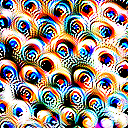

In [11]:
print('pruned feature')

obj  = objectives.channel('features_10',15)

param_f = lambda: param.image(128, sd=2)

make_net_mask_only(pruned_model)
_ = pruned_model.to(device).eval()
_ = render.render_vis(pruned_model, obj,param_f, show_inline=True)

In [1]:
from viscnn.model_prep.utils import load_prepped_model_params, load_prepped_model
from viscnn.dissected_Conv2d import *
model = load_prepped_model('alexnet_sparse')

dissected_model = dissect_model(model, store_activations = False, store_ranks = False, device='cuda')
dissected_model = dissected_model.to('cuda').eval()

/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


original_feature


100%|██████████| 512/512 [00:28<00:00, 18.26it/s]



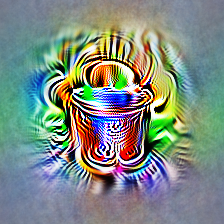

In [4]:
print('original_feature')

obj  = objectives.neuron('features_10',14)
param_f = lambda: param.image(224)

_ = render.render_vis(dissected_model, obj, param_f, transforms=None, show_inline=True)

In [7]:
import lucent
print(lucent.__file__)

/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/lucent/__init__.py


In [12]:
import sys
sys.path

['/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse',
 '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer',
 '/home/chris/miniconda3/envs/viscnn/lib/python37.zip',
 '/home/chris/miniconda3/envs/viscnn/lib/python3.7',
 '/home/chris/miniconda3/envs/viscnn/lib/python3.7/lib-dynload',
 '',
 '/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages',
 '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer',
 '/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/IPython/extensions',
 '/home/chris/.ipython']